# Multilabel classification of personality types

In [1]:
import pandas as pd

In [59]:
#Import data
df = pd.read_excel('../../data/essays.xlsx')

In [60]:
#Replace string representations of target variables to boolean
personalities=["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]

for personality in personalities:
    df[personality].replace(["y", "n"], [1, 0], inplace=True)

df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1


### Sentiment represenatation of text

For sentiment analysis of given essays Vader library is used. This library gives each word in text a score depending on if it is considered positive or negative. Final score is given as a normalized sum.

In [17]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ilinardic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [61]:
sid = SentimentIntensityAnalyzer()
vader=lambda x: sid.polarity_scores(x)['compound']

df['vader_review'] = df['TEXT'].apply(vader)

In [62]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,vader_review
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1,0.9982
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0,0.9978
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1,0.9659
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0,0.9961
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1,0.9896


<Axes: >

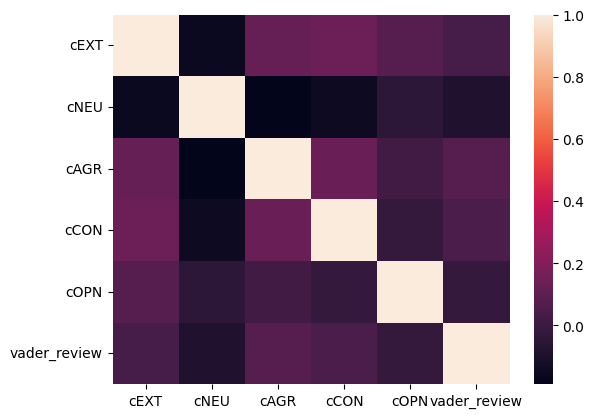

In [96]:
#Correlation of vader sentiment score with each personality

import seaborn as sns

df['vader_review'].describe()
df_corrs = df[["cEXT", "cNEU", "cAGR", "cCON", "cOPN", "vader_review"]]
sns.heatmap(df_corrs.corr())

### Text preprocessing

In [64]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


def clean_text(text):
    """
    Removes and replaces all whitespaces with single spaces. Transforms all letters to lowercase.
    Returns preprocessed text.
    """
    text = text.lower()
    return re.sub(r'\s+', ' ', text)


stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    """
    Removes stopwords from given text.
    :param text: a text string
    :return: list of words from given text without stopwords
    """
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


stemmer = SnowballStemmer("english")


def stemming(sentence):
    """
    Transforms words in a sentence into stems.
    :param sentence:
    :return: list of words from given sentence in stem form
    """
    stem_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stem_sentence += stem
        stem_sentence += " "
    stem_sentence = stem_sentence.strip()
    return stem_sentence

In [65]:
# df["TEXT"] = df.TEXT.apply(remove_stopwords)
df["TEXT"] = df.TEXT.apply(clean_text)
df["TEXT"] = df.TEXT.apply(stemming)

Stop words were later commented because final metrics are better with stop words included.

In [66]:
df.drop(columns='#AUTHID', inplace=True)
df.head()

,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,vader_review
0,"well, right now i just woke up from a mid-day ...",0,1,1,0,1,0.9982
1,"well, here we go with the stream of conscious ...",0,0,1,0,0,0.9978
2,an open keyboard and button to push. the thing...,0,1,0,1,1,0.9659
3,i can't believ it! it realli happening! my pul...,1,0,1,1,0,0.9961
4,"well, here i go with the good old stream of co...",1,0,1,0,1,0.9896


### Model training

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Load vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [68]:
df_TFIDF = df[['TEXT', 'vader_review']]
df_COUNT = df[['TEXT', 'vader_review']]

##### Model training with count vectorizer

In [74]:
count_matrix = count_vectorizer.fit_transform(df_COUNT.TEXT)
count_df = pd.DataFrame(count_matrix.toarray())

In [75]:
count_df['vader_review'] = df_COUNT['vader_review']

In [76]:
from sklearn.model_selection import train_test_split

df_y = df[["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]]

X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

In [77]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

count_base_classifier = LogisticRegression()
count_classifier_chain = ClassifierChain(count_base_classifier)
count_classifier_chain.fit(X_train, y_train)
count_predictions = count_classifier_chain.predict(X_test)

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

##### Model training with tfidf vectorizer

In [78]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df_TFIDF.TEXT)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

In [79]:
tfidf_df['vader_review'] = df_TFIDF['vader_review']

In [80]:
from sklearn.model_selection import train_test_split

df_y = df[["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]]

X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

In [81]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

tfidf_base_classifier = LogisticRegression()
tfidf_classifier_chain = ClassifierChain(tfidf_base_classifier)
tfidf_classifier_chain.fit(X_train, y_train)
tfidf_predictions = tfidf_classifier_chain.predict(X_test)

### Results

In [86]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

Model with count vectorizer embeddings

In [94]:
print(classification_report(y_true=y_test, y_pred=count_predictions))
print("Accuracy score:", accuracy_score(y_true=y_test, y_pred=count_predictions))
print("F1 score:", f1_score(y_pred=count_predictions, y_true=y_test, average='weighted'))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       267
           1       0.53      0.61      0.57       234
           2       0.56      0.51      0.54       274
           3       0.58      0.54      0.56       267
           4       0.58      0.54      0.56       257

   micro avg       0.56      0.54      0.55      1299
   macro avg       0.57      0.54      0.55      1299
weighted avg       0.57      0.54      0.55      1299
 samples avg       0.53      0.53      0.49      1299

Accuracy score: 0.06477732793522267
F1 score: 0.5520494446820515


C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with tf-idf vectorizer

In [95]:
print(classification_report(y_true=y_test, y_pred=tfidf_predictions))
print("Accuracy score:", accuracy_score(y_true=y_test, y_pred=tfidf_predictions))
print("F1 score:", f1_score(y_pred=tfidf_predictions, y_true=y_test, average='weighted'))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       267
           1       0.50      0.50      0.50       234
           2       0.61      0.62      0.62       274
           3       0.57      0.58      0.58       267
           4       0.60      0.60      0.60       257

   micro avg       0.58      0.58      0.58      1299
   macro avg       0.57      0.58      0.58      1299
weighted avg       0.58      0.58      0.58      1299
 samples avg       0.56      0.57      0.53      1299

Accuracy score: 0.08299595141700405
F1 score: 0.5780036275645904


C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
